# Optimización de Riego con Enjambre de Partículas

Este notebook aplica el algoritmo de enjambre de partículas bioinspiradas (PSO) a la industria agrícola. El objetivo es optimizar la colocación de sensores en un campo agrícola para maximizar la eficiencia del riego. 💧 Su algoritmo debe encontrar la mejor distribución de sensores teniendo en cuenta las siguientes variables:

In [8]:
# %% --------------------------------------------- IMPORTS -----------------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import cdist


In [9]:
# %% --------------------------------------------- FUNCIONES Y PSO --------------------------------------------------
def pso_optimize(cost_function, n_particles=30, dimensions=2, bounds=(0, 100), 
                 c1=2.05, c2=2.05, w=0.7, max_iter=100):
    lower, upper = bounds
    pos = np.random.uniform(lower, upper, (n_particles, dimensions))
    vel = np.random.uniform(-1, 1, (n_particles, dimensions))
    pbest_pos = pos.copy()
    pbest_val = cost_function(pos)
    gbest_idx = np.argmin(pbest_val)
    gbest_pos = pbest_pos[gbest_idx].copy()
    gbest_val = pbest_val[gbest_idx]

    for _ in range(max_iter):
        r1, r2 = np.random.rand(n_particles, dimensions), np.random.rand(n_particles, dimensions)
        vel = (w * vel 
               + c1 * r1 * (pbest_pos - pos) 
               + c2 * r2 * (gbest_pos - pos))
        pos = np.clip(pos + vel, lower, upper)

        cost = cost_function(pos)
        better_mask = cost < pbest_val
        if np.any(better_mask):
            pbest_pos[better_mask] = pos[better_mask]
            pbest_val[better_mask] = cost[better_mask]

        best_idx = np.argmin(pbest_val)
        if pbest_val[best_idx] < gbest_val:
            gbest_pos = pbest_pos[best_idx].copy()
            gbest_val = pbest_val[best_idx]

    return gbest_pos, gbest_val


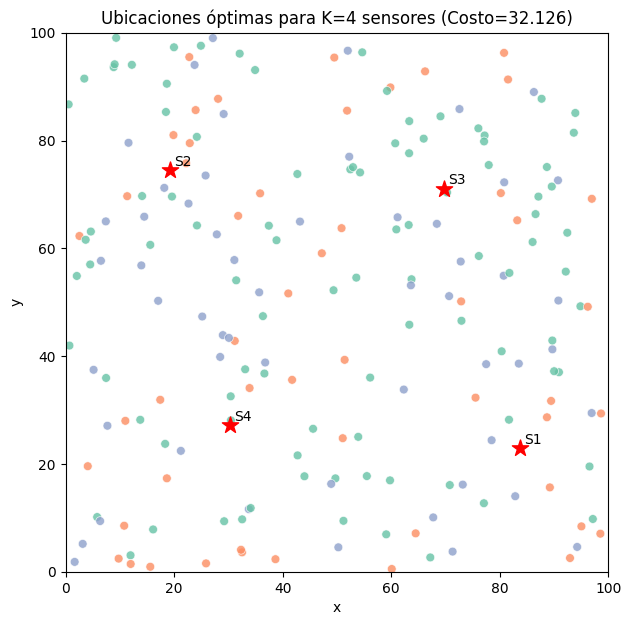

In [ ]:
# %% --------------------------------------------- PRUEBAS FUNCIONALES ------------------------------------------------
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# === Funciones auxiliares ===
def generate_data(num_puntos, seed=42):
    rng = np.random.RandomState(seed)
    x = rng.uniform(0, 100, num_puntos)
    y = rng.uniform(0, 100, num_puntos)
    cultivos = rng.choice(['Maíz', 'Tomate', 'Chile'], num_puntos, p=[0.5, 0.3, 0.2])
    elev = 10 + 40 * rng.rand(num_puntos) + rng.normal(0, 1, num_puntos)
    salinidad = 0.5 + 3.5 * rng.rand(num_puntos) + 0.5 * np.exp(-((x-50)**2+(y-50)**2)/(2*600))
    humedad_target = np.array([0.6 if c=='Maíz' else 0.55 if c=='Tomate' else 0.5 for c in cultivos])
    humedad = np.clip(humedad_target + rng.normal(0, 0.07, num_puntos) - 0.005*(elev-30)/20, 0, 1)

    return pd.DataFrame({
        'x': x, 'y': y, 'cultivo': cultivos,
        'elevacion': elev, 'salinidad': salinidad, 'humedad': humedad
    })


def prepare_models(df, k_reg=5):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df[['x','y']])
    kr_humedad = KNeighborsRegressor(n_neighbors=k_reg).fit(X, df['humedad'])
    kr_elev = KNeighborsRegressor(n_neighbors=k_reg).fit(X, df['elevacion'])
    kr_sal = KNeighborsRegressor(n_neighbors=k_reg).fit(X, df['salinidad'])
    kc_cult = KNeighborsClassifier(n_neighbors=k_reg).fit(X, df['cultivo'])
    return scaler, kr_humedad, kr_elev, kr_sal, kc_cult


def calcular_costo_multisensor(particle, df, scaler, kr_h, kr_e, kr_s, kc_c, K):
    sensores = particle.reshape(K,2)
    dists = cdist(df[['x','y']].values, sensores, metric='euclidean')
    min_dist = dists.min(axis=1)

    # Pesos de prioridad según condiciones agrícolas
    peso_cultivo = df['cultivo'].map({'Maíz':1.2, 'Tomate':1.1, 'Chile':1.0}).values
    peso_sal = 1.0 + (df['salinidad'] - df['salinidad'].min()) / (df['salinidad'].max() - df['salinidad'].min())

    elev = df['elevacion'].to_numpy()  # <- conversión correcta a array NumPy
    peso_elev = 1.0 + (elev.mean() - elev) / (elev.ptp() + 1e-6)

    costo = np.mean(min_dist * peso_cultivo * peso_sal * peso_elev)
    return costo


def cost_func_batch(positions, df, scaler, kr_h, kr_e, kr_s, kc_c, K):
    """Evalúa el costo para todas las partículas (rows) a la vez."""
    costs = []
    for particle in positions:
        c = calcular_costo_multisensor(particle, df, scaler, kr_h, kr_e, kr_s, kc_c, K)
        costs.append(c)
    return np.array(costs)


# === Parámetros PSO ===
K = 4
dimensions = 2*K
lower = np.array([0.0]*(dimensions))
upper = np.array([100.0]*(dimensions))
bounds = (lower, upper)

# preparar df y modelos
df = generate_data(200, seed=42)
scaler, kr_h, kr_e, kr_s, kc_c = prepare_models(df)

# cost batch lambda
cost_batch = lambda positions: cost_func_batch(positions, df, scaler, kr_h, kr_e, kr_s, kc_c, K)

# Ejecutar PSO
best_pos, best_cost = pso_optimize(cost_batch, n_particles=40, dimensions=dimensions, bounds=(lower, upper),
                                   c1=2.05, c2=2.05, w=0.7, max_iter=120)

# === Visualización ===
sensores = best_pos.reshape(K,2)
plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x='x', y='y', hue='cultivo', palette='Set2', s=40, alpha=0.8, legend=False)
plt.scatter(sensores[:,0], sensores[:,1], c='red', s=150, marker='*')
for i,(sx,sy) in enumerate(sensores):
    plt.text(sx+0.8, sy+0.8, f"S{i+1}", color='black')
plt.xlim(0,100); plt.ylim(0,100)
plt.title(f"Ubicaciones óptimas para K={K} sensores (Costo={best_cost:.3f})")
plt.show()


## Pruebas funcionales


🧪 Escenario: Normal


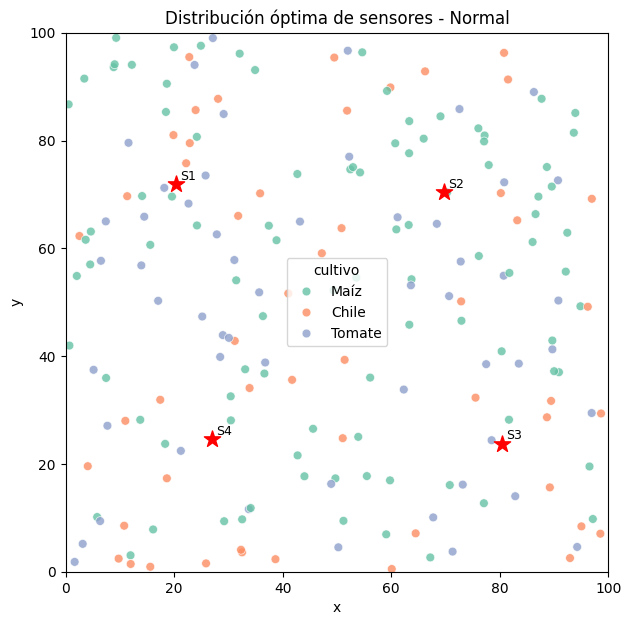


🧪 Escenario: Alta salinidad


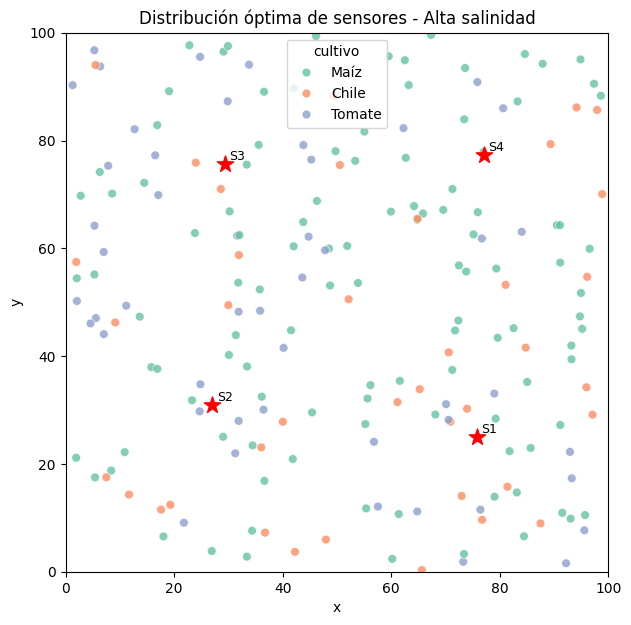


🧪 Escenario: Terreno inclinado


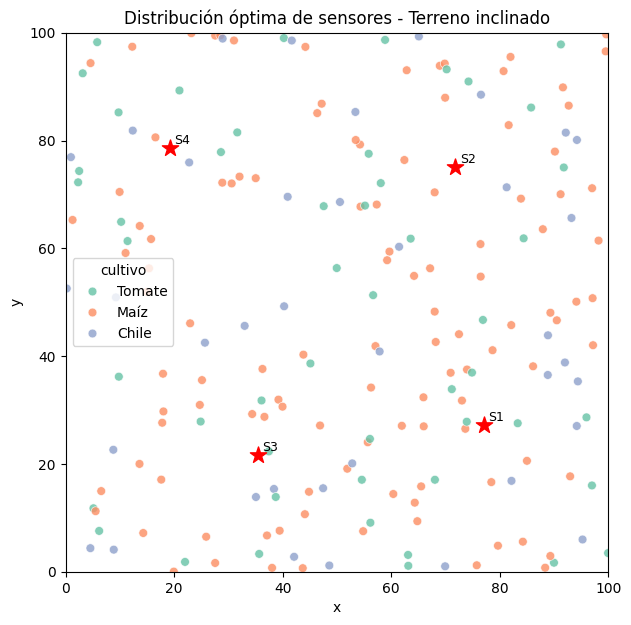

,Escenario,Costo final
0,Normal,32.276561
1,Alta salinidad,32.043045
2,Terreno inclinado,33.198975


In [16]:
# %% --------------------------------------------- PRUEBAS FUNCIONALES ------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Definimos tres configuraciones de terreno para probar la robustez del algoritmo
scenarios = {
    "Normal": {"seed": 42, "variacion_altura": 1.0, "variacion_sal": 1.0},
    "Alta salinidad": {"seed": 11, "variacion_altura": 1.0, "variacion_sal": 3.0},
    "Terreno inclinado": {"seed": 24, "variacion_altura": 3.0, "variacion_sal": 1.0},
}

results = []

for name, cfg in scenarios.items():
    print(f"\n🧪 Escenario: {name}")
    
    # --- Generar dataset adaptado ---
    df_test = generate_data(200, seed=cfg["seed"])
    df_test["elevacion"] += np.sin(df_test["x"]/10)*cfg["variacion_altura"]
    df_test["salinidad"] *= cfg["variacion_sal"]

    # --- Preparar modelos e instancias ---
    scaler, kr_h, kr_e, kr_s, kc_c = prepare_models(df_test)
    cost_batch = lambda positions: cost_func_batch(positions, df_test, scaler, kr_h, kr_e, kr_s, kc_c, K)

    # --- Ejecutar PSO ---
    best_pos, best_cost = pso_optimize(
        cost_batch,
        n_particles=40,
        dimensions=dimensions,
        bounds=(lower, upper),
        c1=2.05, c2=2.05, w=0.7, max_iter=80
    )

    # --- Guardar resultados ---
    results.append({
        "Escenario": name,
        "Costo final": best_cost,
        "Coordenadas óptimas": best_pos.reshape(K,2)
    })

    # --- Visualizar resultado ---
    sensores = best_pos.reshape(K, 2)
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df_test, x='x', y='y', hue='cultivo', palette='Set2', s=40, alpha=0.8)
    plt.scatter(sensores[:,0], sensores[:,1], c='red', s=150, marker='*')
    for i, (sx, sy) in enumerate(sensores):
        plt.text(sx+0.8, sy+0.8, f"S{i+1}", color='black', fontsize=9)
    plt.title(f"Distribución óptima de sensores - {name}")
    plt.xlim(0,100); plt.ylim(0,100)
    plt.show()

# Mostrar tabla resumen
pd.DataFrame(results)[["Escenario", "Costo final"]]
